In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../../data/stackoverflow_sample_125k.tsv'
DS_FILE_NAME_test = '../../data/stackoverflow_sample_12.5k_test.tsv'
TAGS_FILE_NAME = '../../data/top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'java', 'html', 'c++', 'jquery', 'c#', 'android', 'python', 'javascript', 'ios', 'php'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x_i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x_i$ – это выражение моделируется линейной функцией от признаков объекта и параметров модели для класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания; если предпочитаете текст, то и он есть [тут](https://www.ics.uci.edu/~pjsadows/notes.pdf) и [тут](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>

<font color="red">Вопрос 1.</font> Ваше первое задание –  записать упрощенное выражение логарифма правдоподобия примера с признаками $\vec{x}$. Как правило, многие алгоритмы оптимизации имеют интерфейс для минимизации функции, мы последуем этой же традиции и домножим полученное выражение на $-1$, а во второй части выведем формулы для минимизации полученного выражения.

<font color="red">Варианты ответа:</font>
1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

## 2. Вывод формулы обновления весов

<font color="red">Вопрос 2.</font>В качестве второго задания вам предоставляется возможность вывести формулу градиента для $-\mathcal{L}$. Какой вид она будет иметь?

<font color="red">Варианты ответа:</font>:
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

## 3. Реализация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$, если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. В нашем случае, чтобы не пересчитывать [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) самим или с помощью [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), мы будем идти по словам предложения в порядке их следования. Если какое-то слово встречается несколько раз, то мы добавляем его в аккумулятор со своим весом. В итоге получится то же самое, как если сначала посчитать количество одинаковых слов и домножить на соответствующий вес. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-z}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку и реализовать $\sigma$ без риска overflow.

In [51]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    z = self._b[tag]
                    
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    if z <= 0:
                        sigma = np.exp(z) / (1 + np.exp(z))
                    else:
                        sigma = 1 / (1 + np.exp(-z))
    
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sample_loss += -(y*np.log(np.maximum(sigma, tolerance)) + \
                                     (1-y)*np.log(np.maximum(1-sigma, tolerance)))
#                     sample_loss += -(y*np.log(sigma + tolerance) + (1-y)*np.log(1-sigma + tolerance))
                 
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = (y-sigma)

                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)

In [52]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
model.iterate_file()

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))

Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 тысяч примеров, чтобы хоть как-то сгладить график.

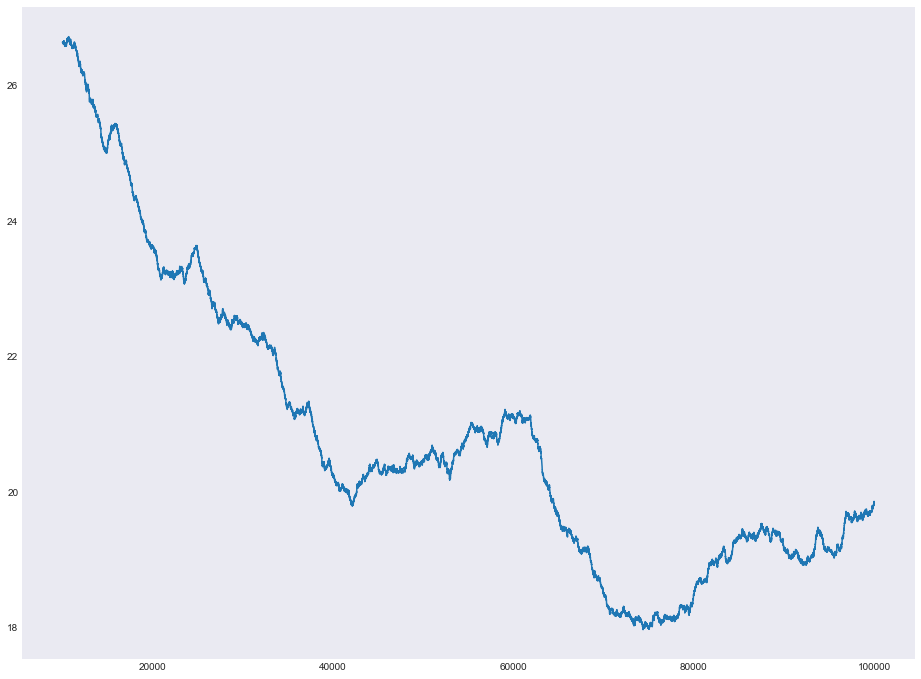

In [53]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [55]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.85


<font color="red">Вопрос 3.</font>
Вычислите среднее значение функции стоимости на последних 10 000 примеров тренировочного набора, к какому из значений ваш ответ ближе всего?

<font color="red">Варианты ответа:</font>
1. 17.54
2. 18.64
3. 19.74
4. 20.84

## 5. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической корректности мы используем грязный трюк: будем регуляризировать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение (bias) не регуляризируется. `sample_loss` тоже должен остаться без изменений.

Замечание:
- не забудьте, что нужно учитывать регуляризацию слова в градиентном шаге только один раз
- условимся, что учитываем регуляризацию только при первой встрече слова
- если бы мы считали сначала bag-of-words, то мы бы в цикле шли по уникальным словам, но т.к. мы этого не делаем, приходится выкручиваться (еще одна жертва богу online-моделей)

In [80]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16, 
                     lmbda=0.01):
        
        self._loss = []
        n = 0
        jaccar = []
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # инициализируем z
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    z = self._b[tag]
                    
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    if z <= 0:
                        sigma = np.exp(z) / (1 + np.exp(z))
                    else:
                        sigma = 1 / (1 + np.exp(-z))
    
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sample_loss += -(y*np.log(np.maximum(sigma, tolerance)) + \
                                     (1-y)*np.log(np.maximum(1-sigma, tolerance)))
#                     sample_loss += -(y*np.log(sigma + tolerance) + (1-y)*np.log(1-sigma + tolerance))
                 
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = y - sigma
                        
                        l2_reg = 0
                        seen_words = set()
#                         for i in set(sentence):
#                             l2_reg += lmbda * self._w[tag][self._vocab[i]]
                        
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:
                            if word in seen_words:
                                ind = 0
                            else:
                                ind = 1
                                l2_reg = lmbda * self._w[tag][self._vocab[word]]
                                seen_words.add(word)
                            self._w[tag][self._vocab[word]] -= learning_rate*(-dLdw + ind * l2_reg)
                        self._b[tag] -= -learning_rate*dLdw
                        
                # если мы уже в тестовой части файла, то тут начинаем предсказывать и считать точность
                if n >= top_n_train:
                    predicted_tags = []
                    for tag_i in self._tags:
                        z = self._b[tag_i]
                        
                        for word in sentence:
                            if word not in self._vocab:
                                self._vocab[word] = len(self._vocab)
                            z += self._w[tag_i][self._vocab[word]]
                        
                        if z <= 0:
                            prob = np.exp(z) / (1 + np.exp(z))
                        else:
                            prob = 1 / (1 + np.exp(-z))
                        
                        if prob > 0.9:
                            predicted_tags.append(tag_i)
                            
                    jac_i = len(np.intersect1d(list(tags),predicted_tags))/len(set(list(tags)+predicted_tags))
                    jaccar.append(jac_i)
                    
#                     if np.random.random()>0.9:
#                         print(tags)
#                         print(predicted_tags)
#                         print('=================')
                        
                n += 1
                        
                self._loss.append(sample_loss)
        return np.mean(jaccar)

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.55


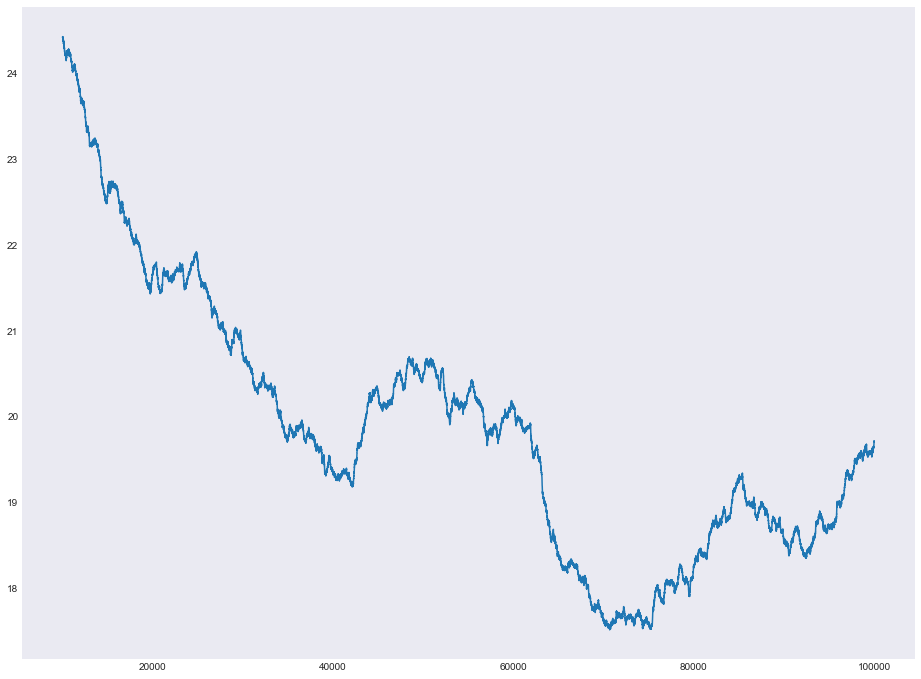

In [81]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());